# AI vs Human Art ML Project


Introduction: This notebook our submission for our Machine Learning final project. This project aims to use image classification to predict AI art or human art images.

### Step 1: Data Loading




In [9]:
import pathlib
# import all the required packages
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import pathlib
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import class_weight
import random
import cv2
import os

import numpy as np

#### Loading the Training Data:
The training data and test data must be loaded differently as the train folder has the typical structure of having subfolders for the 2 classes. The test folder doesn't have any subfolders so the images are not divided by their classes.

The training split will be 70 %

In [2]:
# Loading the training data
labels = ['AI_GENERATED', 'NON_AI_GENERATED']
img_size = 224
batch_size = 32

# File path to the training data
data_dir = pathlib.Path('data/train')

# Loading the training data
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3, # Set aside 30% of the data for validation
    subset="training", # The remaining 70% is kept for training
    seed=123, # Seed helps ensure the same shuffle order
    image_size=(img_size, img_size),
    batch_size= batch_size,
)

# Load the validation data
val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation", # This keeps the 30% for validation
    seed=123, # Matches the seed from the training data
    image_size=(img_size, img_size),
    batch_size= batch_size,
)


Found 18618 files belonging to 2 classes.
Using 13033 files for training.
Found 18618 files belonging to 2 classes.
Using 5585 files for validation.


In [3]:
# Checking the class names are correct
class_names = train_data.class_names
print(f"Classes found: {class_names}")

Classes found: ['AI_GENERATED', 'NON_AI_GENERATED']


The class names were correctly loaded. The actual file structure:
[Insert Picture]
/n

Now to load the test data, adjusting for its structure. To do this I decided to create a subfolder in the test data named unknown. Doing this allows the same tf.keras.utils.image_dataset_from_directory to be used for the test data. This function looks for a subfolder so if this unknown folder is not there the function will fail and return no files found. This was a simplier fix then creating a custom function to adjust this issue.

In [5]:
# Load the test data
test_dir = 'data/test'
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode=None, # No labels should be used for testing
    shuffle = False, # The order should be preserved for the testing data so the predictions generated during modeling could be matched to each image
)

Found 43442 files.


The number of files in the test data matches the amount of data described in the original source(Kaggle), so the data has been loaded correctly

# Step 2: Visualize the data

AI_GENERATED : 7238
NON_AI_GENERATED : 5795


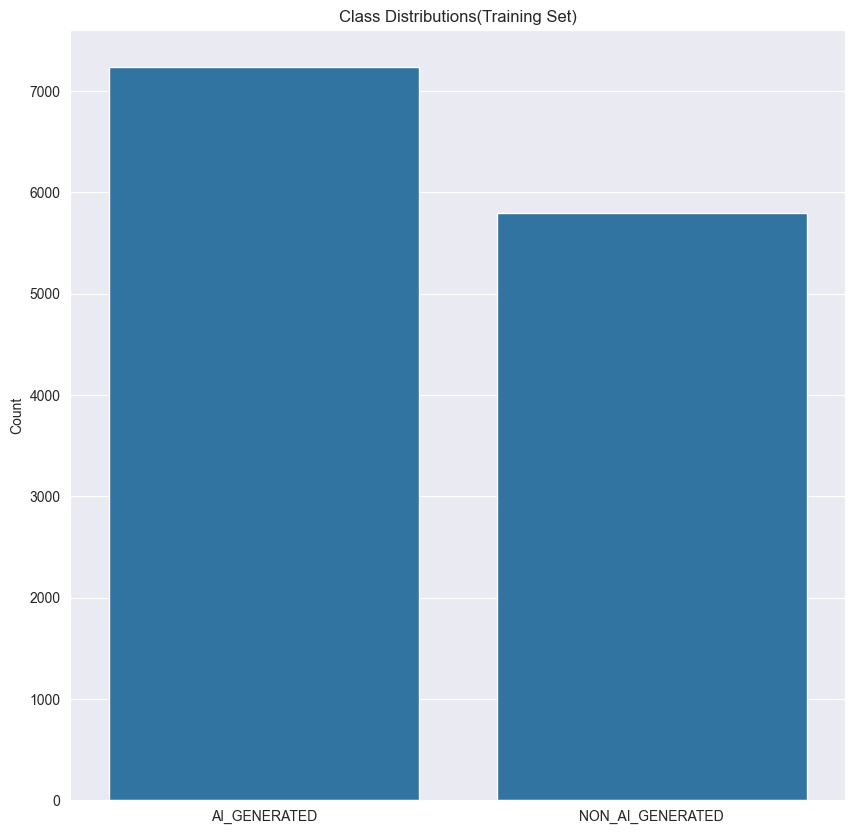

In [8]:
# Visualize the classes in the training data
y_labels = []

# Collecting the labels from the training data
for images, labels in train_data:
    y_labels.extend(labels.numpy())

# Assign the labels
class_names = train_data.class_names
l = [class_names[label] for label in y_labels]

# Print the counts for each class
for name in class_names:
    count= l.count(name)
    print(f"{name} : {count}")

# Plot the counts for the classes
plt.figure(figsize=(10, 10))
sns.countplot(x = l)
plt.title("Class Distributions(Training Set)")
plt.ylabel("Count")
plt.show()

Imbalanced data :(


In order to handle this imbalance we will implement class weights. A higher weight will be applied to the NON_AI class so there will be a higher penalty placed on errors made on the NON_AI class this way the classes will be more balanced despite the difference in the counts.


For now lets continue to make some visualizations on the data



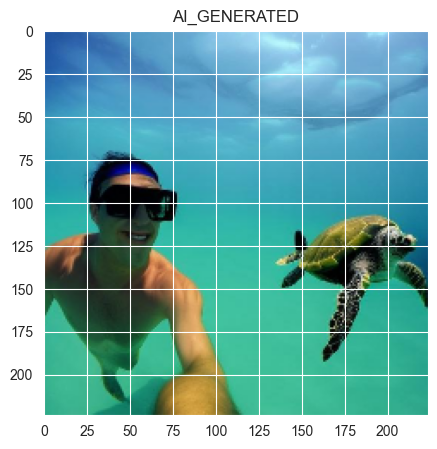

In [25]:
# Preview an image from the training data
# Get the first batch in the data
image_batch, label_batch = next(iter(train_data))
idx = 0

# Create the plot
plt.figure(figsize=(5, 5))
plt.imshow(image_batch[idx].numpy().astype("uint8"))
label_index = label_batch[idx]
plt.title(class_names[label_index])
plt.axis("on") # Show a grid
plt.show()

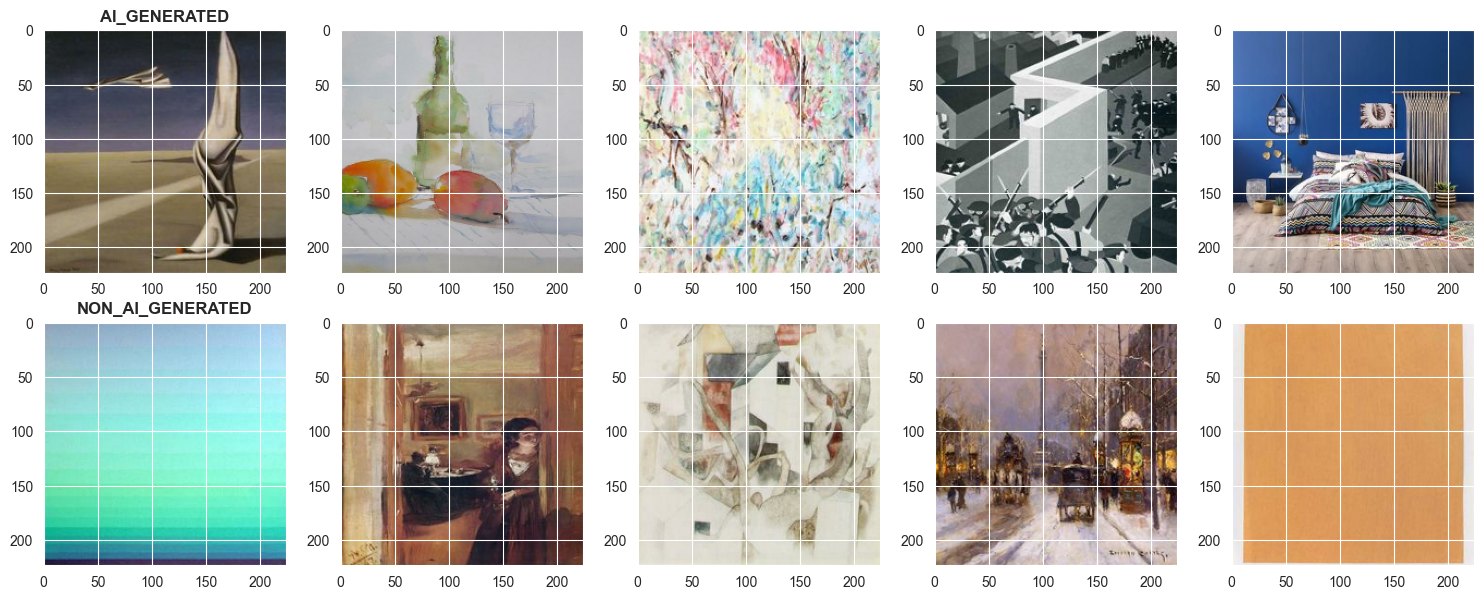

In [29]:
# Preview 5 images from each class
def preview_image(dataset, num_img = 5):
    ai =[]
    real =[]

    for images, labels in dataset:
        batch_imgs = images.numpy().astype("uint8")
        batch_labels = labels.numpy()

        # Iterate through the images in the batch
        for i in range(len(batch_labels)):
            if batch_labels[i] and  len(ai) < num_img:
                ai.append(batch_imgs[i])

            elif batch_labels[i] == 1 and len(real) < num_img:
                real.append(batch_imgs[i])

        if len(ai) >= num_img and len(real) >= num_img:
            break

    # Create Plot
    fig, axes = plt.subplots(2, num_img, figsize=(15, 6))
    class_names = dataset.class_names # ['AI_GENERATED', 'NON_AI_GENERATED']

    # Row 1: AI Images
    for i in range(num_img):
        axes[0, i].imshow(ai[i])
        if i == 0:
            axes[0, i].set_title(class_names[0], fontsize=12, fontweight='bold')

    # Row 2: Real Images
    for i in range(num_img):
        axes[1, i].imshow(real[i])
        if i == 0:
            axes[1, i].set_title(class_names[1], fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

preview_image(train_data, num_img=5)

# Step 2: Data Preprocessing and Data Augmentation

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Your specific counts
count_ai = 7238
count_non_ai = 5795
total = count_ai + count_non_ai

# Method A: Manual Calculation (Good for understanding)
# Formula: Total_Samples / (2 * Class_Count)
weight_0 = total / (2 * count_ai)      # AI_GENERATED (Class 0)
weight_1 = total / (2 * count_non_ai)  # NON_AI_GENERATED (Class 1)

class_weights = {0: weight_0, 1: weight_1}

print(f"Weight for Class 0 (AI): {weight_0:.2f}")     # Should be approx 0.90
print(f"Weight for Class 1 (Non-AI): {weight_1:.2f}") # Should be approx 1.12

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split file paths into train and validation (80/20 split)
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

print(f"Training samples: {len(train_paths_split)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

# ========== ADD DATA AUGMENTATION ==========
# Create augmentation object for training
augmentor = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Modified generator WITH augmentation for training
def augmented_data_generator(file_paths, file_labels, batch_size=32, shuffle=True, augment=True):
    """Generator with optional data augmentation"""
    indices = np.arange(len(file_paths))

    while True:
        if shuffle:
            np.random.shuffle(indices)

        for start_idx in range(0, len(file_paths), batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                try:
                    img_arr = cv2.imread(file_paths[idx])[...,::-1]  # BGR to RGB
                    if img_arr is None:
                        continue
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    normalized = resized_arr.astype(np.float32) / 255.0

                    batch_images.append(normalized)
                    batch_labels.append(file_labels[idx])
                except Exception as e:
                    print(f"Error loading {file_paths[idx]}: {e}")
                    continue

            if len(batch_images) > 0:
                batch_images = np.array(batch_images)
                batch_labels = np.array(batch_labels)

                # Apply augmentation only if requested
                if augment:
                    aug_gen = augmentor.flow(batch_images, batch_labels, batch_size=len(batch_images), shuffle=False)
                    batch_images, batch_labels = next(aug_gen)

                yield batch_images, batch_labels

# Create generators
batch_size = 32

# Training generator WITH augmentation
train_gen = augmented_data_generator(train_paths_split, train_labels_split, batch_size=batch_size, shuffle=True, augment=True)

# Validation generator WITHOUT augmentation
val_gen = augmented_data_generator(val_paths, val_labels, batch_size=batch_size, shuffle=False, augment=False)

# Test generator (no labels, no augmentation)
test_gen = test_data_generator(test_paths, batch_size=batch_size)

# Calculate steps for training
steps_per_epoch = len(train_paths_split) // batch_size
validation_steps = len(val_paths) // batch_size
test_steps = len(test_paths) // batch_size + 1  # +1 to include remaining images

print(f"\nSteps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")

# Step 3: Define the model

In [ ]:
model = Sequential()
model.add(Conv2D(32, 3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # For integer labels (0, 1)
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=20,
    verbose=1
)

# Step 4: Train the Model

# Step 5: Evaluating the Result

In [ ]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

In [ ]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

In [ ]:
# ========== 2. Print Final Metrics ==========
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("\n" + "="*50)
print("FINAL TRAINING RESULTS")
print("="*50)
print(f"Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Training Loss:       {final_train_loss:.4f}")
print(f"Validation Loss:     {final_val_loss:.4f}")
print("="*50)

In [ ]:
# ========== 3. Evaluate on Validation Set ==========
print("\nEvaluating on validation set...")
val_loss, val_accuracy = model.evaluate(val_gen, steps=validation_steps, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")


In [ ]:
# ========== 4. Make Predictions on Test Set ==========
print("\nMaking predictions on test set...")
predictions = model.predict(test_gen, steps=test_steps, verbose=1)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)

print(f"\nTotal test predictions: {len(predicted_classes)}")
print(f"Predicted as AI_GENERATED: {np.sum(predicted_classes == 0)} ({np.sum(predicted_classes == 0)/len(predicted_classes)*100:.1f}%)")
print(f"Predicted as NON_AI_GENERATED: {np.sum(predicted_classes == 1)} ({np.sum(predicted_classes == 1)/len(predicted_classes)*100:.1f}%)")
print(f"Average confidence: {np.mean(confidence_scores):.2%}")

In [ ]:
# ========== 5. Show Sample Predictions ==========
print("\n" + "="*50)
print("SAMPLE TEST PREDICTIONS")
print("="*50)

# Get a few random test images
sample_indices = np.random.choice(len(test_paths), min(10, len(test_paths)), replace=False)

for idx in sample_indices:
    pred_class = predicted_classes[idx]
    confidence = confidence_scores[idx]
    print(f"\nImage: {os.path.basename(test_paths[idx])}")
    print(f"  Predicted: {labels[pred_class]}")
    print(f"  Confidence: {confidence:.2%}")


In [ ]:
# ========== 5. Show Sample Predictions ==========
print("\n" + "="*50)
print("SAMPLE TEST PREDICTIONS")
print("="*50)

# Get a few random test images
sample_indices = np.random.choice(len(test_paths), min(10, len(test_paths)), replace=False)

for idx in sample_indices:
    pred_class = predicted_classes[idx]
    confidence = confidence_scores[idx]
    print(f"\nImage: {os.path.basename(test_paths[idx])}")
    print(f"  Predicted: {labels[pred_class]}")
    print(f"  Confidence: {confidence:.2%}")

plt.tight_layout()
plt.show()
